In [4]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import pruning stuff
import tensorflow_model_optimization as tfmot

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [5]:
# #code for GPU mem growth

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


In [6]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [7]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [17]:
#build data generators for training and validaton

split = 0.2

total_train = 84
total_val = 20


# Define dirs and files
train_data_dir = '../data/portenta'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 320
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,1)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    color_mode = 'grayscale',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        color_mode = 'grayscale',
                                                        target_size = imsize,
                                                        subset='validation')

Found 84 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [18]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [19]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=16, kernel_size=3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(32, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation = "softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 160, 160, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [20]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = acc_metric)

In [21]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 40,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/40
5/5 [==============================] - 0s 93ms/step - loss: 0.6945 - acc: 0.5588 - val_loss: 0.6999 - val_acc: 0.4375
Epoch 2/40
5/5 [==============================] - 0s 70ms/step - loss: 0.6883 - acc: 0.5441 - val_loss: 0.6760 - val_acc: 0.5625
Epoch 3/40
5/5 [==============================] - 0s 68ms/step - loss: 0.6846 - acc: 0.5294 - val_loss: 0.6802 - val_acc: 0.5000
Epoch 4/40
5/5 [==============================] - 0s 69ms/step - loss: 0.7062 - acc: 0.5000 - val_loss: 0.6735 - val_acc: 0.5625
Epoch 5/40
5/5 [==============================] - 0s 75ms/step - loss: 0.6734 - acc: 0.6176 - val_loss: 0.6715 - val_acc: 0.8750
Epoch 6/40
5/5 [==============================] - 0s 65ms/step - loss: 0.6784 - acc: 0.5294 - val_loss: 0.6621 - val_acc: 0.8750
Epoch 7/40
5/5 [==============================] - 0s 77ms/step - loss: 0.6707 - acc: 0.6500 - val_loss: 0.6607 - val_acc: 0.8750
Epoch 8/40
5/5 [==============================] - 0s 77ms/step - loss: 0.6463 - acc: 0.7375 - val

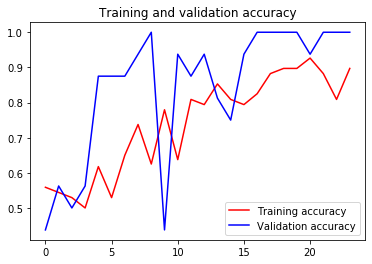

<Figure size 432x288 with 0 Axes>

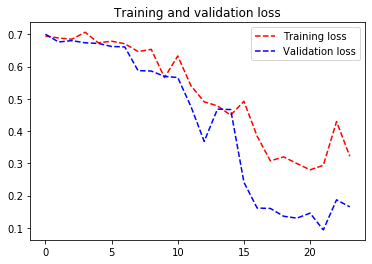

<Figure size 432x288 with 0 Axes>

In [22]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
#save the model
filepath = './models/MokaPotNet_reg'
model.save(filepath)


INFO:tensorflow:Assets written to: ./models/MokaPotNet_reg/assets


In [33]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


epochs = 10


end_step = np.ceil(1.0 * total_train / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.8,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = acc_metric)

model_for_pruning.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_3 (None, 160, 160, 16)      306       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 80, 80, 16)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_4 (None, 40, 40, 32)        9250      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 20, 20, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_5 (None, 10, 10, 64)        36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 5, 5, 64)          1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 1600)             

In [34]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

phistory = model_for_pruning.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= epochs,
                    validation_steps =  total_val // batch_size,
                    callbacks =callbacks)

Epoch 1/10
5/5 [==============================] - 1s 113ms/step - loss: 0.2756 - acc: 0.8810 - val_loss: 0.0637 - val_acc: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 70ms/step - loss: 0.3391 - acc: 0.8971 - val_loss: 0.1300 - val_acc: 0.9375
Epoch 3/10
5/5 [==============================] - 0s 78ms/step - loss: 0.1773 - acc: 0.9625 - val_loss: 0.0494 - val_acc: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 76ms/step - loss: 0.1999 - acc: 0.9375 - val_loss: 0.0835 - val_acc: 0.9375
Epoch 5/10
5/5 [==============================] - 0s 70ms/step - loss: 0.1866 - acc: 0.9412 - val_loss: 0.0548 - val_acc: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 69ms/step - loss: 0.2400 - acc: 0.9265 - val_loss: 0.0973 - val_acc: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 78ms/step - loss: 0.1930 - acc: 0.9250 - val_loss: 0.0312 - val_acc: 1.0000
Epoch 8/10
5/5 [==============================] - 0s 69ms/step - loss: 0.2175 - acc: 0.9412 - va

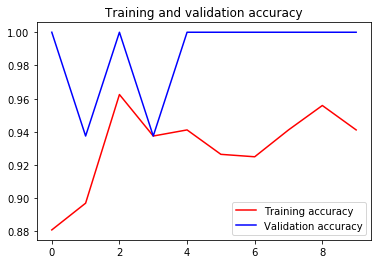

<Figure size 432x288 with 0 Axes>

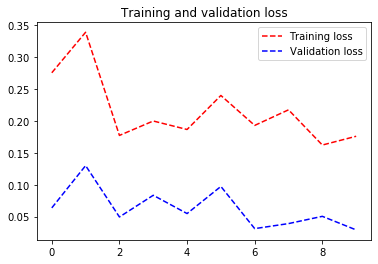

<Figure size 432x288 with 0 Axes>

In [35]:
#look at the metrics from training
%matplotlib inline

acc = phistory.history['acc']
val_acc = phistory.history['val_acc']
loss = phistory.history['loss']
val_loss = phistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [37]:
#get the pruned model ready
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)



# #quantize

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        ## Ideally we should do a validation calibration but we are using all of the training data for max acc
#         x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        x =np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

with open('MokaPotNet_QuantPruned.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)



INFO:tensorflow:Assets written to: /tmp/tmp4gucy4eu/assets


INFO:tensorflow:Assets written to: /tmp/tmp4gucy4eu/assets


(84, 320, 320, 1)
input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [42]:
import os
import zipfile
import tempfile

def get_gzipped_model_size(file):
   #Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size('./models/MokaPotNet_reg/saved_model.pb')))
print("Size of gzipped unpruned TFlite model: %.2f bytes" % (get_gzipped_model_size('./models/MokaPotNet_cat_portenta.tflite')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size( './models/MokaPotNet_QuantPruned.tflite' )))


Size of gzipped baseline Keras model: 22339.00 bytes
Size of gzipped unpruned TFlite model: 231947.00 bytes
Size of gzipped pruned TFlite model: 128316.00 bytes


In [ ]:
# This will also decrease latency..